# Image Segmentation with U-Net

## 1 - Packages

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate


## 2 - Load and Split the Data

In [2]:
import os
import numpy as np
import pandas as pd 

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

### Check the dataset:


Text(0.5, 1.0, 'Segmentation')

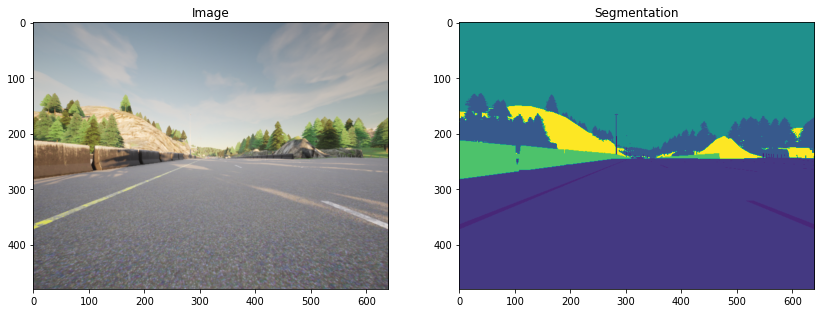

In [3]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### 2.1 - Split Dataset

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

### 2.2 - Preprocess Data

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #or dividing by 255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## 3 - U-Net 

### 3.1 - Eecoder (Downsampling Block)

In [7]:

def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """ Convolutional encoder block """

    conv = Conv2D(n_filters,
                (3,3),   
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                (3,3),
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D()(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 3.2 - Decoder (Upsampling Block)

In [9]:

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """ convolutional decoder block """

    up = Conv2DTranspose(
                n_filters,
                3,
                strides=2,
                padding='same')(expansive_input)
    
    # merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)
                
    return conv

In [11]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """ Unet model """
    inputs = Input(input_size)
    # encoder 
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    # decoder
    ublock6 = upsampling_block(cblock5[0], cblock4[1],   n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)
    #out put model
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


### 3.3 - Set Model Dimensions

In [13]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [14]:
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 96, 128, 32)  896         ['input_6[0][0]']                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_26[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_27[0][0]']        

Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


### 3.4 - Loss Function

In [15]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 3.5 - Display Dataset 

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


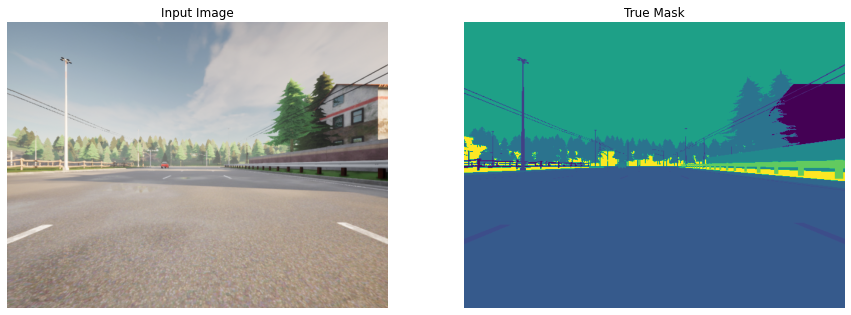

In [17]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


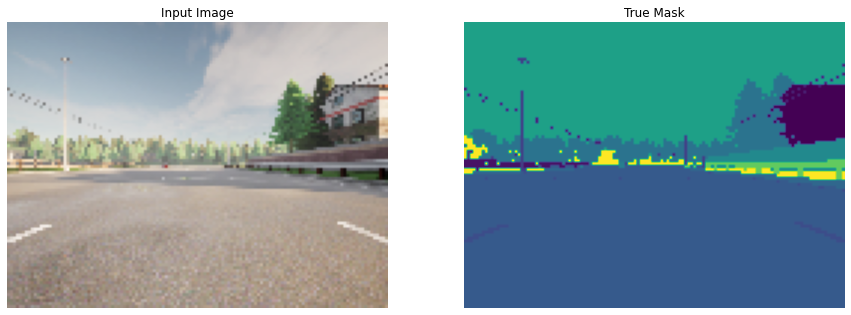

In [18]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## 4 - Train the Model

In [19]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 19s 197ms/step - loss: 1.7985 - accuracy: 0.5291
Epoch 2/5
34/34 [==============================] - 2s 58ms/step - loss: 0.7778 - accuracy: 0.7923
Epoch 3/5
34/34 [==============================] - 2s 57ms/step - loss: 0.7833 - accuracy: 0.7957
Epoch 4/5
34/34 [==============================] - 2s 57ms/step - loss: 0.6561 - accuracy: 0.8129
Epoch 5/5
34/34 [==============================] - 2s 57ms/step - loss: 0.5065 - accuracy: 0.8480


### 4.1 - Create Predicted Masks 

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

### 4.2 - Plot Accuracy

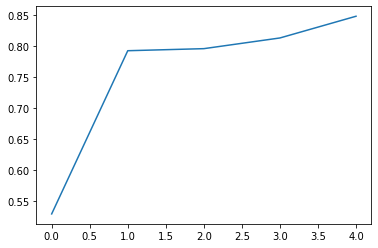

In [21]:
plt.plot(model_history.history["accuracy"])

### 4.3 - Predictions 


In [22]:
def show_predictions(dataset=None, num=1):

    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 218ms/step


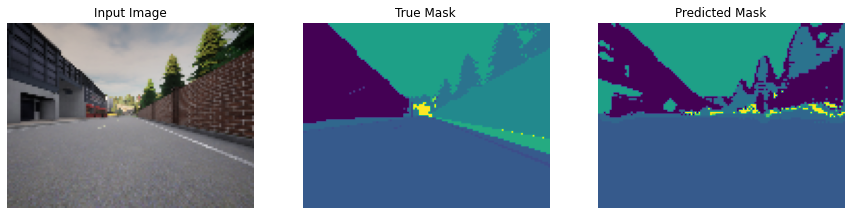

1/1 [==============================] - 0s 20ms/step


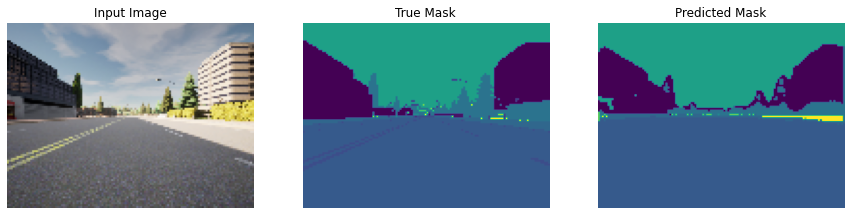

1/1 [==============================] - 0s 20ms/step


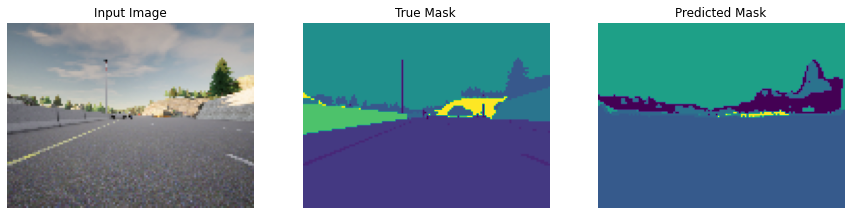

1/1 [==============================] - 0s 20ms/step


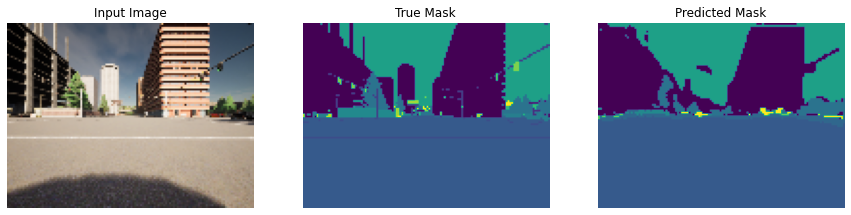

1/1 [==============================] - 0s 36ms/step


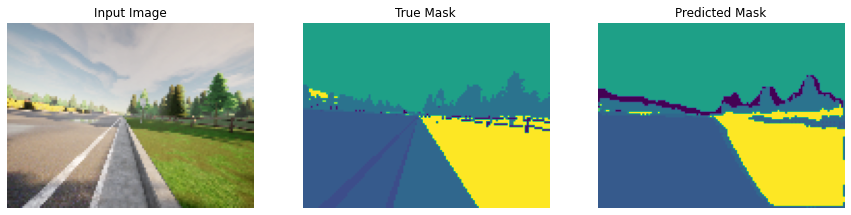

1/1 [==============================] - 0s 19ms/step


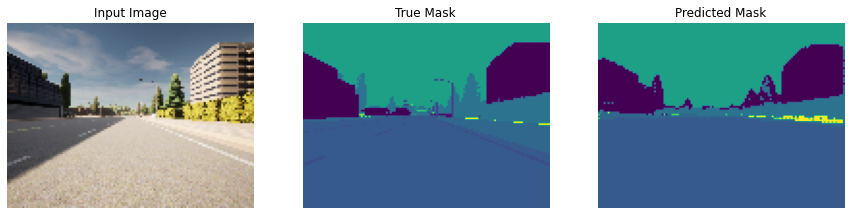

In [23]:
show_predictions(train_dataset, 6)